In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [3]:
# параметры распределений
mu0, sigma0 = -2., 1.
mu1, sigma1 = 3., 2.

In [4]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n, 2)).reshape(-1, 2)
    y0 = torch.zeros((n, 1))
    
    x1 = d1.sample((n, 2)).reshape(-1, 2)
    y1 = torch.ones((n, 1))

    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [5]:
d0 = torch.distributions.Normal(torch.tensor([mu0]), torch.tensor([sigma0]))
d1 = torch.distributions.Normal(torch.tensor([mu1]), torch.tensor([sigma1]))

In [6]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.5799,  0.3424]), tensor(-0.4359)]


In [16]:
log_freq = 500
for i in range(20000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 0.032446
Ошибка после 1 итераций: 0.032870
Ошибка после 2 итераций: 0.032628
Ошибка после 3 итераций: 0.032775
Ошибка после 4 итераций: 0.033200
Ошибка после 5 итераций: 0.031916
Ошибка после 6 итераций: 0.031242
Ошибка после 7 итераций: 0.032303
Ошибка после 8 итераций: 0.031662
Ошибка после 9 итераций: 0.032445
Ошибка после 10 итераций: 0.032757
Ошибка после 11 итераций: 0.032057
Ошибка после 12 итераций: 0.031730
Ошибка после 13 итераций: 0.031933
Ошибка после 14 итераций: 0.031772
Ошибка после 15 итераций: 0.031050
Ошибка после 16 итераций: 0.031774
Ошибка после 17 итераций: 0.032132
Ошибка после 18 итераций: 0.031223
Ошибка после 19 итераций: 0.031160
Ошибка после 20 итераций: 0.032209
Ошибка после 21 итераций: 0.031782
Ошибка после 22 итераций: 0.032159
Ошибка после 23 итераций: 0.031142
Ошибка после 24 итераций: 0.031472
Ошибка после 25 итераций: 0.030918
Ошибка после 26 итераций: 0.031301
Ошибка после 27 итераций: 0.030773
Ошибка после 28 итераций: 0.03

In [17]:
width = 200

x_scale = np.linspace(-10, 10, width)
y_scale = np.linspace(-10, 10, width)

X, Y = np.meshgrid(x_scale, y_scale)
print([x_scale, y_scale])


points = np.stack([X, Y], axis=2)
xy_tensor = torch.tensor(points, dtype=torch.float)
with torch.no_grad():
    predictions = torch.sigmoid(layer(xy_tensor)).reshape([width, width]).numpy()

d0_pdf = stats.norm.pdf(x_scale, mu0, sigma0) 
d1_pdf = stats.norm.pdf(x_scale, mu1, sigma1)

D0_l, D0_r = np.meshgrid( d0_pdf, d0_pdf )
D0 = D0_l * D0_r

D1_l, D1_r = np.meshgrid( d1_pdf, d1_pdf )
D1 = D1_l * D1_r

r = D1 / (D0 + D1)

[array([-10.        ,  -9.89949749,  -9.79899497,  -9.69849246,
        -9.59798995,  -9.49748744,  -9.39698492,  -9.29648241,
        -9.1959799 ,  -9.09547739,  -8.99497487,  -8.89447236,
        -8.79396985,  -8.69346734,  -8.59296482,  -8.49246231,
        -8.3919598 ,  -8.29145729,  -8.19095477,  -8.09045226,
        -7.98994975,  -7.88944724,  -7.78894472,  -7.68844221,
        -7.5879397 ,  -7.48743719,  -7.38693467,  -7.28643216,
        -7.18592965,  -7.08542714,  -6.98492462,  -6.88442211,
        -6.7839196 ,  -6.68341709,  -6.58291457,  -6.48241206,
        -6.38190955,  -6.28140704,  -6.18090452,  -6.08040201,
        -5.9798995 ,  -5.87939698,  -5.77889447,  -5.67839196,
        -5.57788945,  -5.47738693,  -5.37688442,  -5.27638191,
        -5.1758794 ,  -5.07537688,  -4.97487437,  -4.87437186,
        -4.77386935,  -4.67336683,  -4.57286432,  -4.47236181,
        -4.3718593 ,  -4.27135678,  -4.17085427,  -4.07035176,
        -3.96984925,  -3.86934673,  -3.76884422,  -3.6

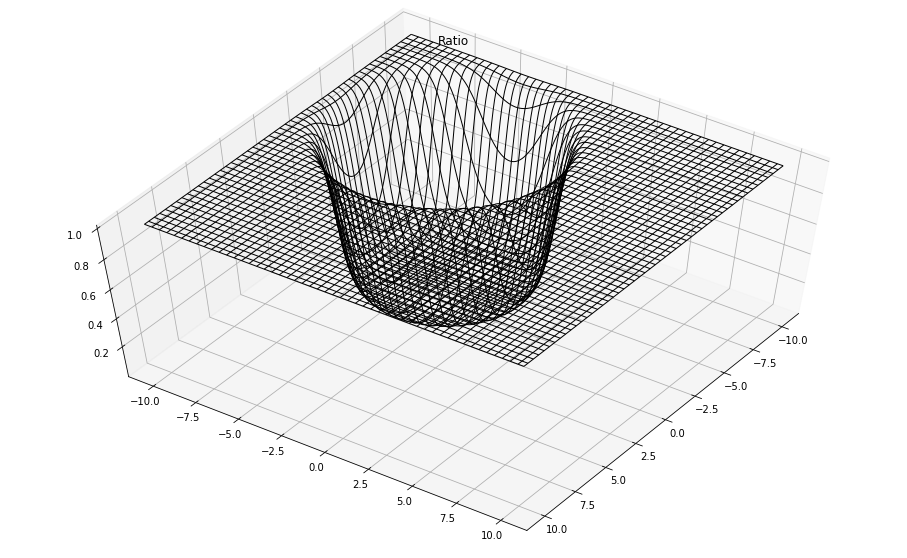

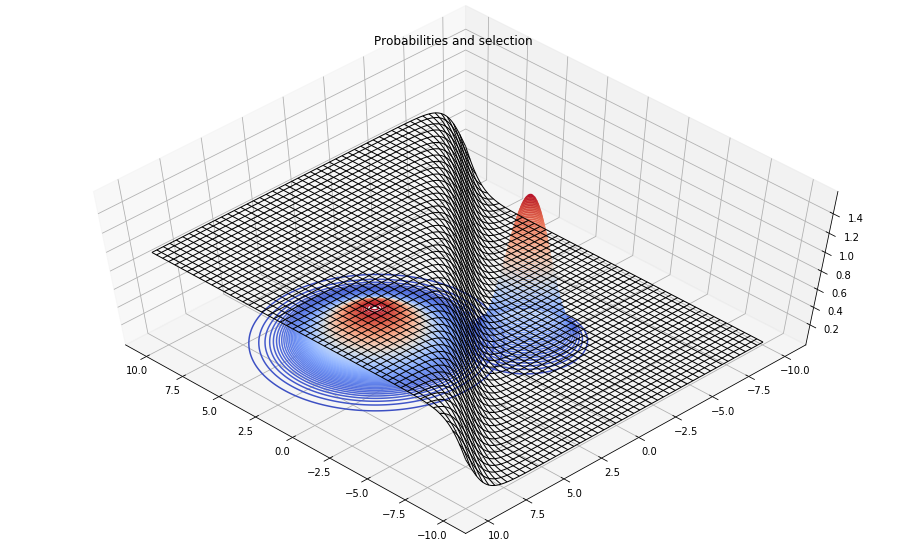

In [20]:
plt.figure(figsize=(16, 10))

ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, r, 1, color='black')
ax.set_title('Ratio')

ax.view_init(60, 35)
plt.show()

fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d')

ax.plot_wireframe(X, Y, predictions, 1, color='black')
ax.contour3D(X, Y, D1 * 10, 100, cmap=cm.coolwarm)
ax.contour3D(X, Y, D0 * 10, 100, cmap=cm.coolwarm)
ax.set_title('Probabilities and selection')

ax.view_init(60, 135)

plt.show()
